转载：[CNN 卷积神经网络](https://morvanzhou.github.io/tutorials/machine-learning/torch/4-01-CNN/)
# MNIST手写数据 

In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision      # 数据库模块
import matplotlib.pyplot as plt

torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 1           # 训练整批数据多少次, 为了节约时间, 我们只训练一次
BATCH_SIZE = 50
LR = 0.001          # 学习率
DOWNLOAD_MNIST = True  # 如果你已经下载好了mnist数据就写上 False


# Mnist 手写数字
train_data = torchvision.datasets.MNIST(
    root='./mnist/',    # 保存或者提取位置
    train=True,  # this is training data
    transform=torchvision.transforms.ToTensor(),    # 转换 PIL.Image or numpy.ndarray 成
                                                    # torch.FloatTensor (C x H x W), 训练的时候 normalize 成 [0.0, 1.0] 区间
    download=DOWNLOAD_MNIST,          # 没下载就下载, 下载了就不用再下了
)

Processing...
Done!


torch.Size([60000, 28, 28])
torch.Size([60000])


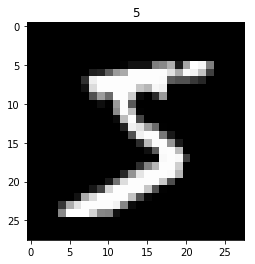

In [4]:
print(train_data.train_data.size())                 # (60000, 28, 28)
print(train_data.train_labels.size())               # (60000)
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

黑色的地方的值都是0, 白色的地方值大于0.

同样, 我们除了训练数据, 还给一些测试数据, 测试看看它有没有训练好.

In [2]:
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)

# 批训练 50samples, 1 channel, 28x28 (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

# 为了节约时间, 我们测试时只测试前2000个
test_x = torch.unsqueeze(test_data.test_data, dim=1).type(torch.FloatTensor)[:2000]/255.   # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_y = test_data.test_labels[:2000]

# CNN模型
和以前一样, 我们用一个 class 来建立 CNN 模型. 这个 CNN 整体流程是 卷积(`Conv2d`) -> 激励函数(`ReLU`) -> 池化, 向下采样 (`MaxPooling`) -> 再来一遍 -> 展平多维的卷积成的特征图 -> 接入全连接层 (`Linear`) -> 输出

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(  # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,      # input height
                out_channels=16,    # n_filters
                kernel_size=5,      # filter size
                stride=1,           # filter movement/step
                padding=2,      # 如果想要 con2d 出来的图片长宽没有变化, padding=(kernel_size-1)/2 当 stride=1
            ),      # output shape (16, 28, 28)
            nn.ReLU(),    # activation
            nn.MaxPool2d(kernel_size=2),    # 在 2x2 空间里向下采样, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(  # input shape (16, 14, 14)
            nn.Conv2d(16, 32, 5, 1, 2),  # output shape (32, 14, 14)
            nn.ReLU(),  # activation
            nn.MaxPool2d(2),  # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)   # 展平多维的卷积图成 (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output

cnn = CNN()
print(cnn)  # net architecture
"""
CNN (
  (conv1): Sequential (
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU ()
    (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (conv2): Sequential (
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU ()
    (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (out): Linear (1568 -> 10)
)
"""

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


'\nCNN (\n  (conv1): Sequential (\n    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))\n    (1): ReLU ()\n    (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))\n  )\n  (conv2): Sequential (\n    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))\n    (1): ReLU ()\n    (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))\n  )\n  (out): Linear (1568 -> 10)\n)\n'

# 训练
下面我们开始训练, 将 `x` `y` 都用 `Variable` 包起来, 然后放入 cnn 中计算 `output`, 最后再计算误差.

('Epoch: ', 0, '| train loss: 0.2943', '| test accuracy: 0.89')


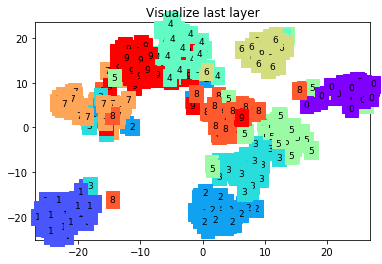

('Epoch: ', 0, '| train loss: 0.3669', '| test accuracy: 0.93')


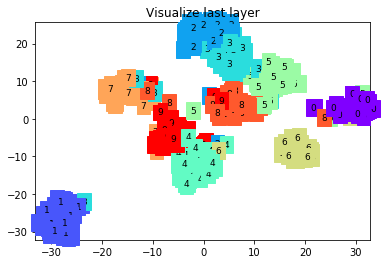

('Epoch: ', 0, '| train loss: 0.1084', '| test accuracy: 0.94')


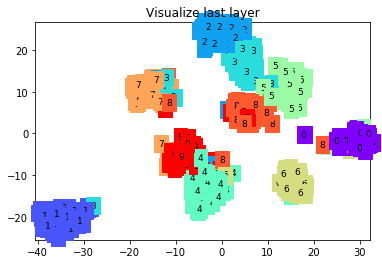

('Epoch: ', 0, '| train loss: 0.1650', '| test accuracy: 0.95')


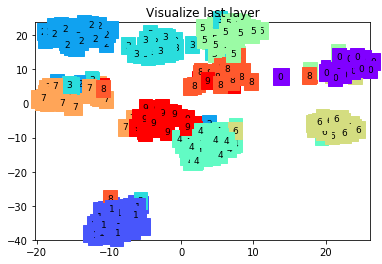

('Epoch: ', 0, '| train loss: 0.0308', '| test accuracy: 0.95')


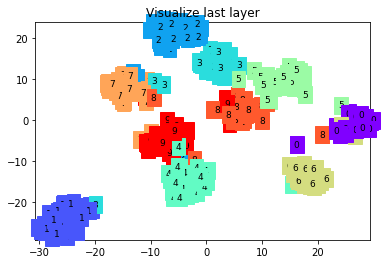

('Epoch: ', 0, '| train loss: 0.1041', '| test accuracy: 0.95')


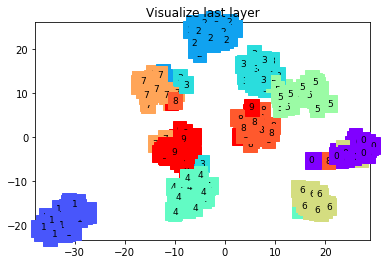

('Epoch: ', 0, '| train loss: 0.1273', '| test accuracy: 0.97')


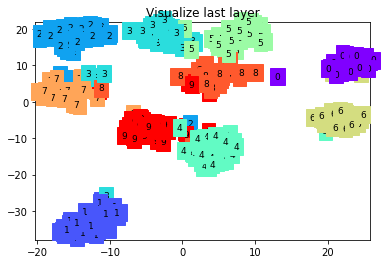

('Epoch: ', 0, '| train loss: 0.1381', '| test accuracy: 0.96')


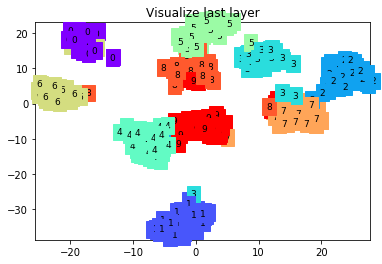

('Epoch: ', 0, '| train loss: 0.0251', '| test accuracy: 0.97')


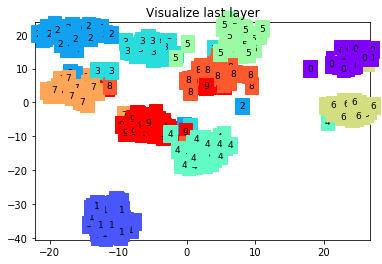

('Epoch: ', 0, '| train loss: 0.0241', '| test accuracy: 0.97')


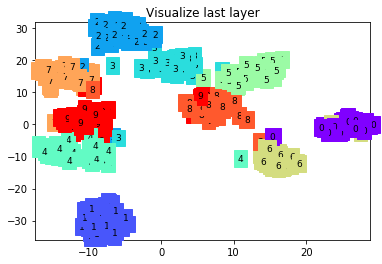

('Epoch: ', 0, '| train loss: 0.0439', '| test accuracy: 0.96')


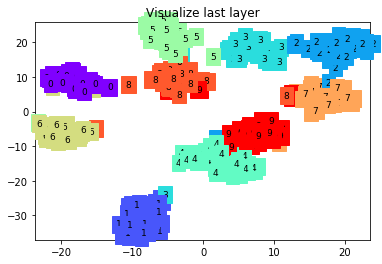

('Epoch: ', 0, '| train loss: 0.0148', '| test accuracy: 0.96')


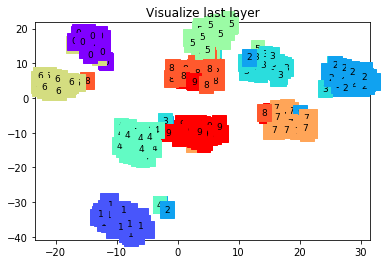

('Epoch: ', 0, '| train loss: 0.1411', '| test accuracy: 0.97')


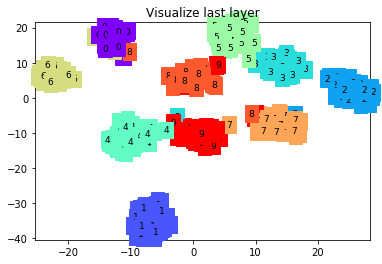

('Epoch: ', 0, '| train loss: 0.0580', '| test accuracy: 0.97')


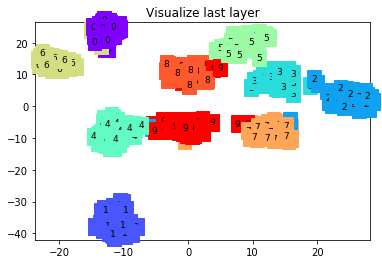

('Epoch: ', 0, '| train loss: 0.0185', '| test accuracy: 0.97')


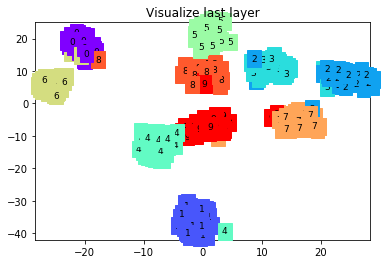

('Epoch: ', 0, '| train loss: 0.0778', '| test accuracy: 0.97')


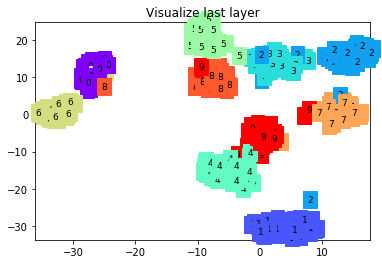

('Epoch: ', 0, '| train loss: 0.0579', '| test accuracy: 0.98')


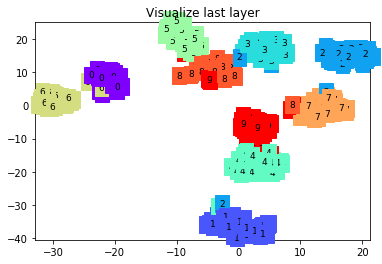

('Epoch: ', 0, '| train loss: 0.0555', '| test accuracy: 0.98')


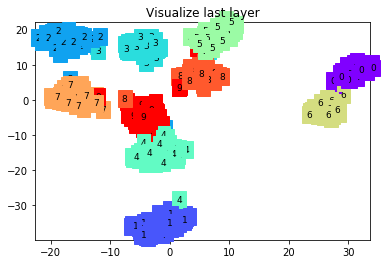

('Epoch: ', 0, '| train loss: 0.0698', '| test accuracy: 0.97')


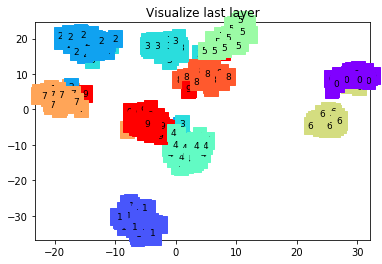

('Epoch: ', 0, '| train loss: 0.1262', '| test accuracy: 0.98')


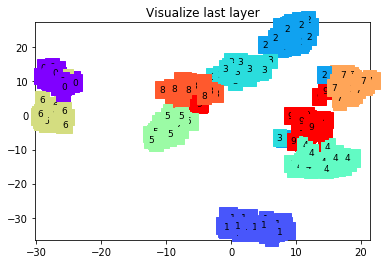

('Epoch: ', 0, '| train loss: 0.1868', '| test accuracy: 0.98')


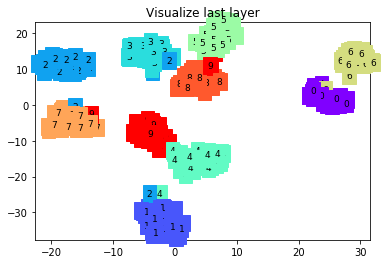

('Epoch: ', 0, '| train loss: 0.0134', '| test accuracy: 0.98')


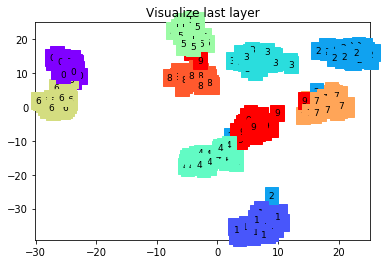

('Epoch: ', 0, '| train loss: 0.0194', '| test accuracy: 0.98')


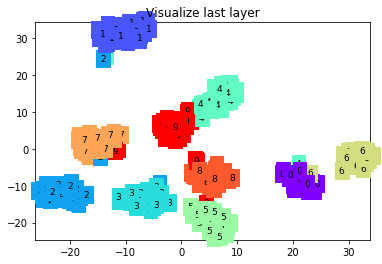

('Epoch: ', 0, '| train loss: 0.2952', '| test accuracy: 0.98')


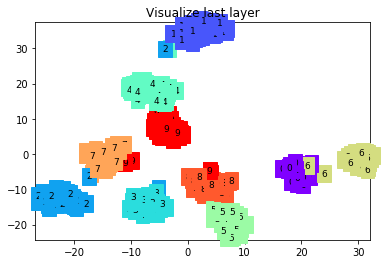

In [31]:
cnn = cnn.cuda()
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

# following function (plot_with_labels) is for visualization, can be ignored if not interested
from matplotlib import cm
from torch.autograd import Variable
try: from sklearn.manifold import TSNE; HAS_SK = True
except: HAS_SK = False; print('Please install sklearn for layer visualization')
def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)

plt.ion()
# training and testing
for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        b_x = b_x.cuda()
        b_y = b_y.cuda()
        output = cnn(Variable(b_x))              # cnn output
        loss = loss_func(output, Variable(b_y))   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 50 == 0:
            test_x = test_x.cuda()
            test_y = test_y.cuda()
            test_output = cnn(Variable(test_x))
            pred_y = torch.max(test_output, 1)[1].data.cpu().squeeze().numpy()
            accuracy = float((pred_y == test_y.cpu().numpy()).astype(int).sum()) / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.cpu().numpy(), '| test accuracy: %.2f' % accuracy)
            if HAS_SK:
                # Visualization of trained flatten layer (T-SNE)
                tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
                plot_only = 500
                low_dim_embs = tsne.fit_transform(test_output.data.cpu().numpy()[:plot_only, :])
                labels = test_y.cpu().numpy()[:plot_only]
                plot_with_labels(low_dim_embs, labels)
plt.ioff()

最后我们再来取10个数据, 看看预测的值到底对不对:

In [36]:
# print 10 predictions from test data
test_output = cnn(Variable(test_x)[:10])
pred_y = torch.max(test_output, 1)[1].data.cpu().numpy().squeeze()
print(pred_y, 'prediction number')
print(test_y[:10].cpu().numpy(), 'real number')

(array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9]), 'prediction number')
(array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9]), 'real number')
